In [239]:
import sys
import warnings
import pandas as pd
import numpy as np
import pyodbc 
import pylab as pl
from scipy import stats
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from IPython.display import Markdown, display, Image

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [137]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [134]:
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [2]:
#Function for printing text in bold
def printmd(string):
    display(Markdown(string))

# 2. Programming questions

### 1. Read data into a pandas dataframe

In [161]:
#Read the csv file into the pandas dataframe
dataset = pd.read_csv("TTIChallenge/Programming_Part1_TTI_Challenge.csv", sep= "\t")

In [162]:
dataset.head()

,Class,PartNo,X,Y
0,AAA,X135,0.21,1.124
1,AAA,X126,0.21,1.179
2,EBHA,X195,0.32,1.191
3,EBHA,X194,0.82,1.249
4,AAA,X139,0.81,1.255


### 2. Compute min, max, average, standard deviation, and the geometric mean for X, Y

In [5]:
#Univariate Analysis of columns X & Y 
dataset.describe()

,X,Y
count,100.000000,100.000000
mean,5.499100,3.525130
std,2.672921,1.734591
min,0.210000,1.124000
25%,3.515000,2.086250
50%,5.310000,2.974000
75%,7.810000,4.919500
max,10.020000,7.498000


In [6]:
#Function to compute the min, max, average, standard deviation, and the geometric mean for X, Y¶
def computeMetrics(col):
    print("Minimum value: ", min(col))
    print("Maximum value: ", max(col))
    print("Average: ", col.mean())
    print("Standard Deviation: ", col.std())
    print("Geometric Mean: ", stats.gmean(col))

In [7]:
printmd("**Summary of X**")
computeMetrics(dataset["X"])

**Summary of X**

Minimum value:  0.21
Maximum value:  10.02
Average:  5.499099999999999
Standard Deviation:  2.672921110438216
Geometric Mean:  4.4953243612


In [8]:
printmd("**Summary of Y**")
computeMetrics(dataset["Y"])

**Summary of Y**

Minimum value:  1.124
Maximum value:  7.497999999999999
Average:  3.5251300000000003
Standard Deviation:  1.7345914411692966
Geometric Mean:  3.10830980506


### 3. How would you write out the dataframe to a SQL table?

In [20]:
#Establish connection to SQL Server Native Client by building the connection string and passing it to the connect 
#method of pyodbc module
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                      "Server=DESKTOP-V873VSB\SQLEXPRESS;"
                      "Database=TTI;"
                      "Trusted_Connection=yes;")
cursor = cnxn.cursor()

In [23]:
#Create a table to store the dataframe
sql_command = """
CREATE TABLE Dataset
(
Class VARCHAR(10),
PartNo VARCHAR(10),
X DECIMAL (5, 2),
Y DECIMAL (5, 3)
)
"""
try:
    cursor.execute(sql_command)
    cnxn.commit()
except pyodbc.ProgrammingError:
    print("Table 'Dataset' already exists.")

In [25]:
#Insert records of the dataframe to the table
for idx, row in dataset.iterrows():
    insertList = row.tolist()
    insertString = ""
    try:
        for item in insertList:  
            if insertString:
                insertString = insertString + ', ' + "\'" + str(item)  + "\'"
            else:
                insertString = "\'" + item + "\'"
   
        
        cursor.execute("""insert into Dataset(    
                        Class, 
                        PartNo, 
                        X, 
                        Y) values ( %s )""" % insertString)
        cnxn.commit()
    except:
        continue

In [27]:
#Fetch records back from the SQL table
cursor.execute("select * from Dataset")
for row in cursor:
    print(row)

('AAA', 'X135', Decimal('0.21'), Decimal('1.124'))
('AAA', 'X126', Decimal('0.21'), Decimal('1.179'))
('EBHA', 'X195', Decimal('0.32'), Decimal('1.191'))
('EBHA', 'X194', Decimal('0.82'), Decimal('1.249'))
('AAA', 'X139', Decimal('0.81'), Decimal('1.255'))
('EBHA', 'X164', Decimal('1.21'), Decimal('1.388'))
('EBHA', 'X184', Decimal('1.01'), Decimal('1.402'))
('AAA', 'X124', Decimal('1.12'), Decimal('1.433'))
('EBHA', 'X196', Decimal('1.80'), Decimal('1.511'))
('EBGB', 'X110', Decimal('1.81'), Decimal('1.528'))
('AAA', 'X148', Decimal('1.51'), Decimal('1.533'))
('AAA', 'X142', Decimal('2.41'), Decimal('1.628'))
('EBHA', 'X185', Decimal('2.12'), Decimal('1.648'))
('AAA', 'X137', Decimal('2.12'), Decimal('1.660'))
('EBHA', 'X168', Decimal('2.31'), Decimal('1.662'))
('AAA', 'X121', Decimal('2.51'), Decimal('1.684'))
('AAA', 'X134', Decimal('2.61'), Decimal('1.686'))
('EBGB', 'X102', Decimal('2.51'), Decimal('1.704'))
('AAA', 'X154', Decimal('2.61'), Decimal('1.790'))
('EBHA', 'X173', Decim

### 4. Generate a predictive model of Y based on X (submit code and results); describe your approach

In [183]:
#Setting the values of the dependent & independent variables
X = dataset.iloc[:, 2].values
y = dataset.iloc[:, 3].values

In [184]:
#Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [204]:
#Reshaping the training set because the regression.fit() method expects a 2D array by default
X_train = X_train.reshape(-1, 1)

In [205]:
#Fitting the linear regression model to the dataset
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [230]:
#Fitting the polynomial regression model to the dataset
poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(X_train)
poly_reg.fit(X_poly, y_train)

lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, y_train)

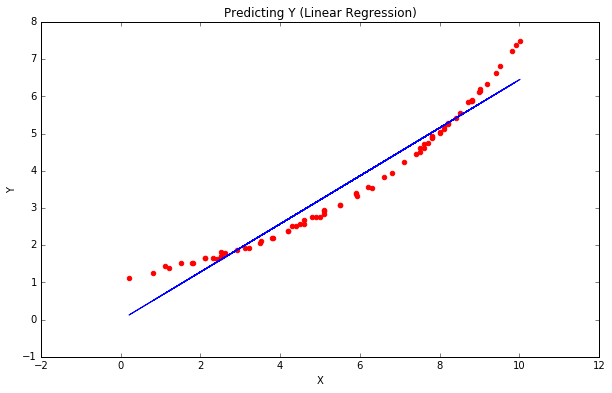

In [211]:
#Visualizing the Linear Regression results
plt.scatter(X_train, y_train, color = "red")
plt.plot(X_train, lin_reg.predict(X_train), color = "blue")
plt.title("Predicting Y (Linear Regression)")
plt.xlabel("X")
plt.ylabel("Y")

Clearly, fitting a simple regression line is not sufficient. A polynomial regression curve will fit the data much better

### 5. Assess the accuracy of your predictive model

In [227]:
#Get the predictions
y_preds = lin_reg_2.predict(poly_reg.fit_transform(X_test.reshape(-1, 1)))

In [228]:
#A utility function for calculating Root Mean Squared Error
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [237]:
#Calculating RMSE for polynomial degrees from 2 to 10
rmseVal = []

for deg in range(2, 11):
    poly_reg = PolynomialFeatures(degree = deg)
    X_poly = poly_reg.fit_transform(X_train)
    poly_reg.fit(X_poly, y_train)

    lin_reg_2 = LinearRegression()
    lin_reg_2.fit(X_poly, y_train)
    
    y_preds = lin_reg_2.predict(poly_reg.fit_transform(X_test.reshape(-1, 1)))
    
    print("RMSE for degree of polynomial", deg)
    residual = rmse(y_preds, y_test)
    rmseVal.append(residual)
    print(residual)
    

RMSE for degree of polynomial 2
0.0904895393421
RMSE for degree of polynomial 3
0.0514430167102
RMSE for degree of polynomial 4
0.0470144658359
RMSE for degree of polynomial 5
0.045986623398
RMSE for degree of polynomial 6
0.0463211935775
RMSE for degree of polynomial 7
0.0485465349951
RMSE for degree of polynomial 8
0.0487178806428
RMSE for degree of polynomial 9
0.050108496414
RMSE for degree of polynomial 10
0.0503528023983


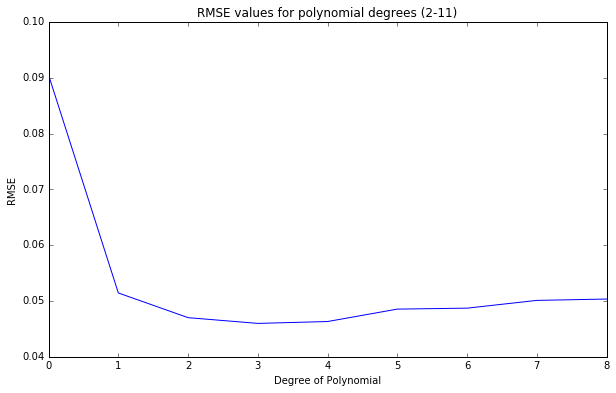

In [238]:
#Plotting RMSE to select the optimal value of the polynomial
plt.plot(rmseVal)
plt.title("RMSE values for polynomial degrees (2-11)")
plt.xlabel("Degree of Polynomial")
plt.ylabel("RMSE")

Polynomial degrees 2, 3, 4 give more or less the same RMSE. We should choose 2 degrees since it won't overfit the data and would be able to generalize the unseen instances much better.

# 3. SQL questions

### The three tables used:

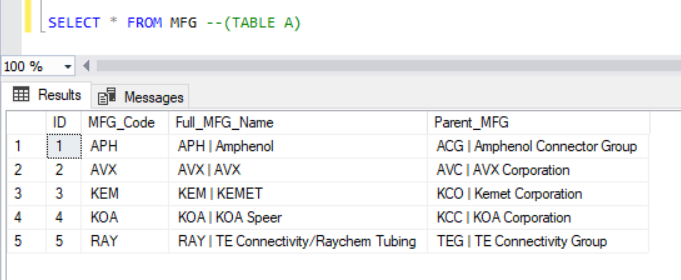

In [144]:
Image("TTIChallenge/SQLResults/Table MFG.png")

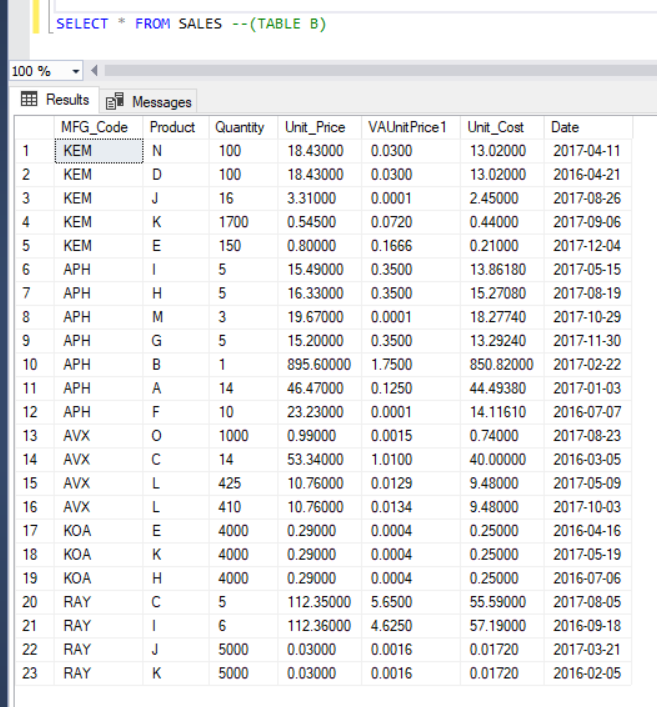

In [145]:
Image("TTIChallenge/SQLResults/Table Sales.png")

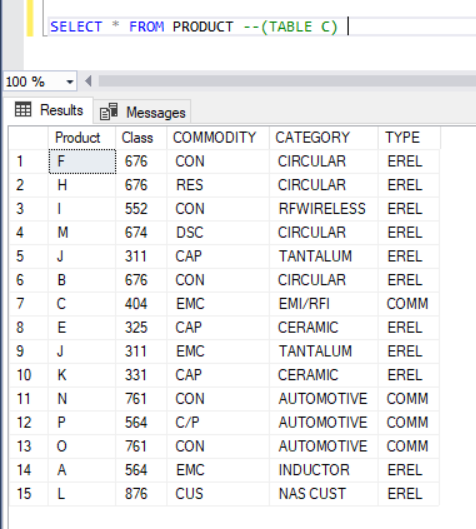

In [146]:
Image("TTIChallenge/SQLResults/Table Product.png")

### 1. Display Full_MFG_Name in Table B without the MFG Code ( Example: ‘Amphenol’)

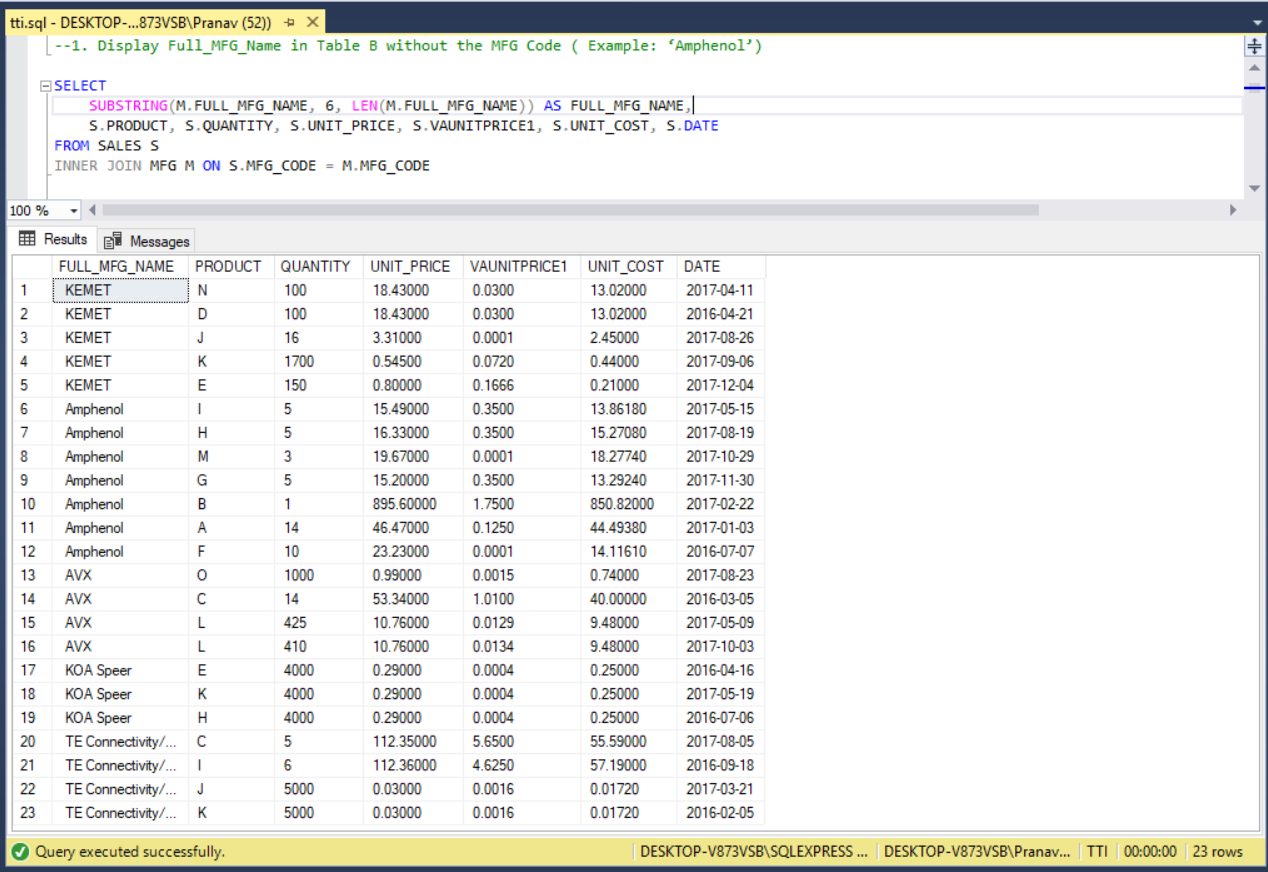

In [147]:
Image("TTIChallenge/SQLResults/Query1.png")

### 2. Calculate Total Revenue from Table B

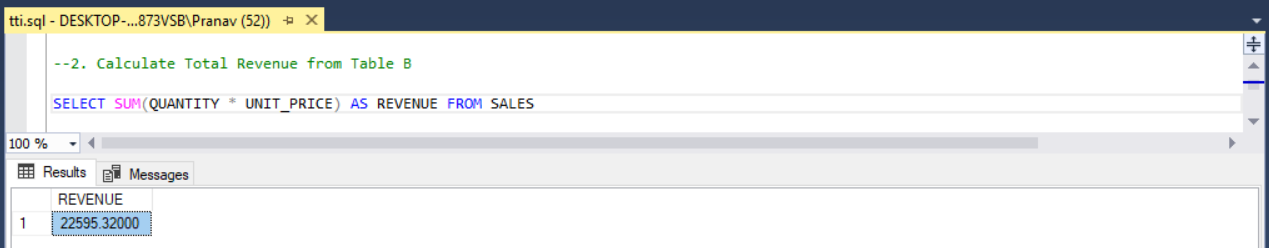

In [148]:
Image("TTIChallenge/SQLResults/Query2.png")

### 3. Display the top 10 Products from Table B which made highest profit

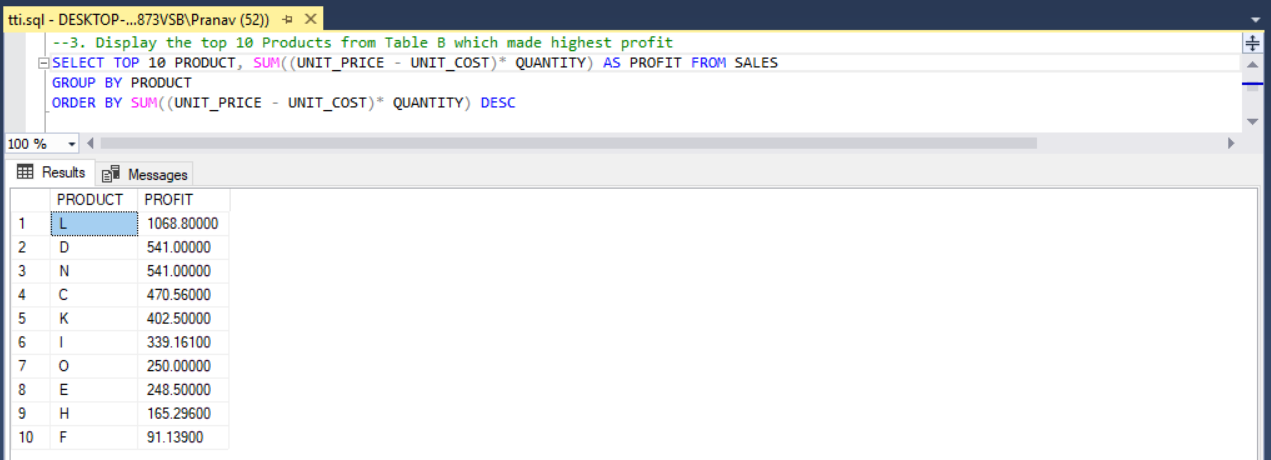

In [149]:
Image("TTIChallenge/SQLResults/Query3.png")

### 4. Display total cost, total Price and Margins grouped by Parent_MFG in table A

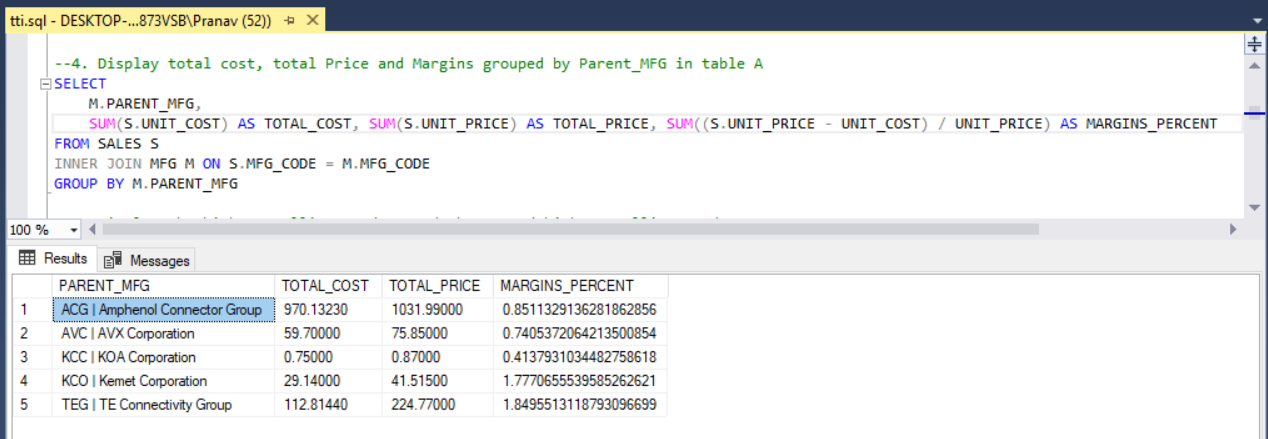

In [150]:
Image("TTIChallenge/SQLResults/Query4.png")

### 5. Display the highest selling product and the second highest selling product

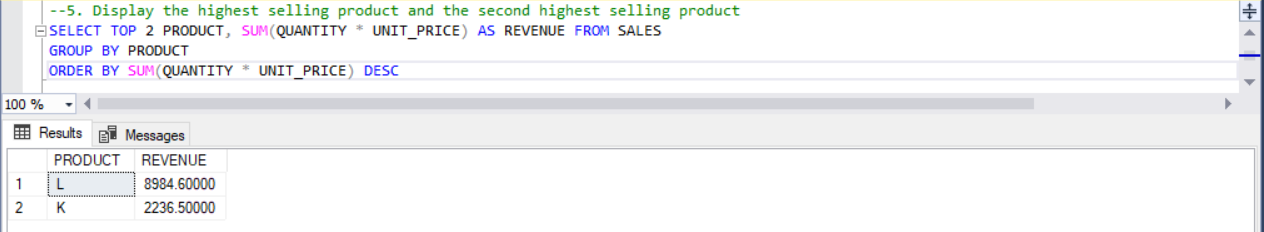

In [151]:
Image("TTIChallenge/SQLResults/Query5.png")

### 6. Display the Total Cost and Total Revenue based on Type from Table C and order it in a descending order

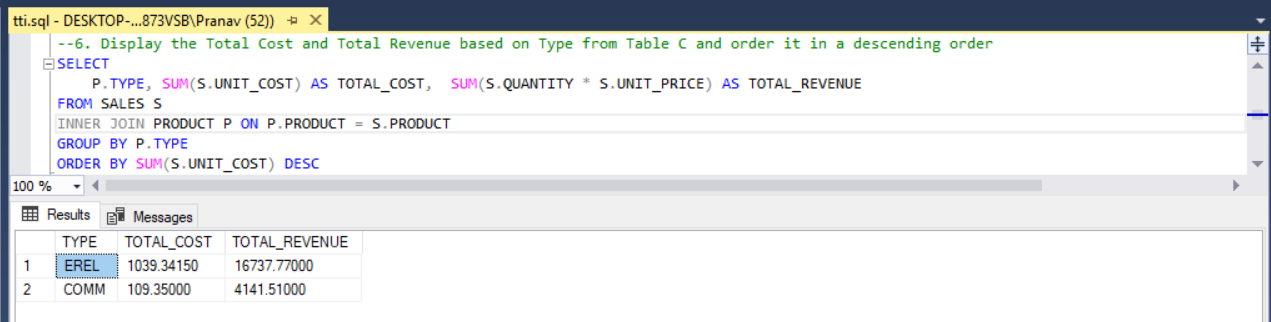

In [152]:
Image("TTIChallenge/SQLResults/Query6.png")

### 7. Find which Quarter sold highest number of products

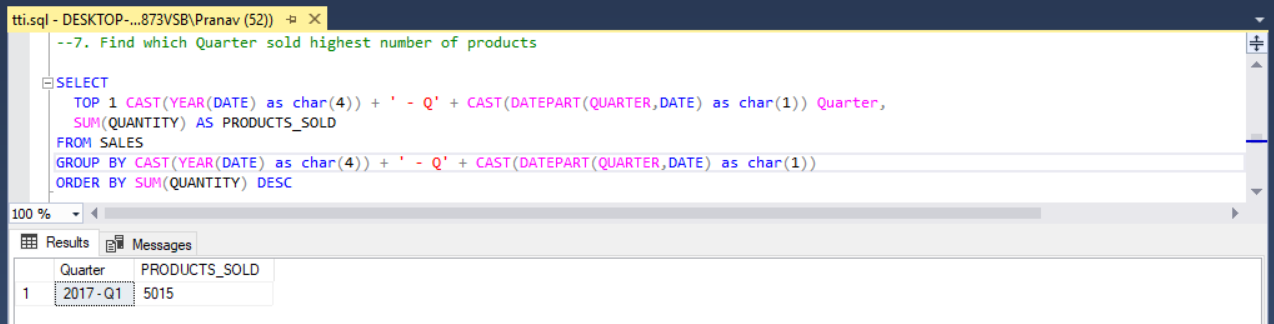

In [153]:
Image("TTIChallenge/SQLResults/Query7.png")

### 8. Find which quarter made the highest sale in ‘AUTOMOTIVE’ category In the last year

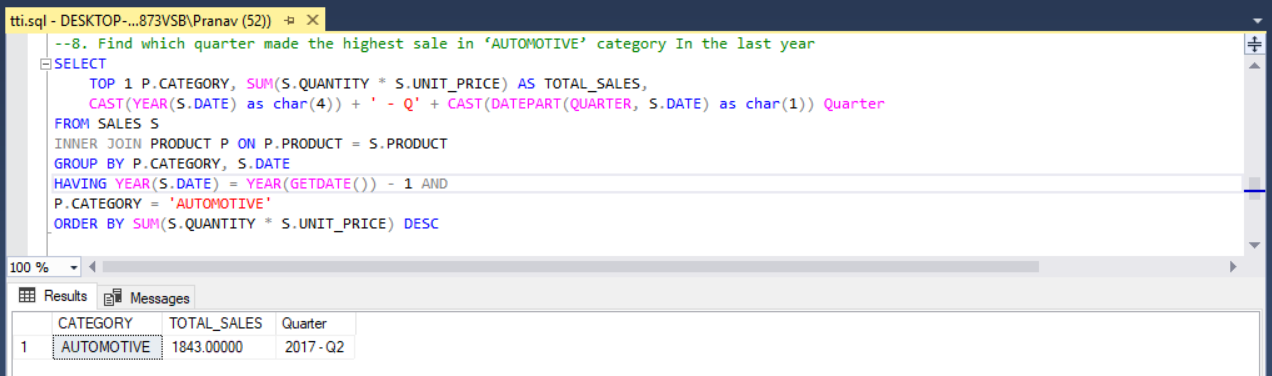

In [154]:
Image("TTIChallenge/SQLResults/Query8.png")

### 9. Find the Products in table C that haven’t sold anything ever

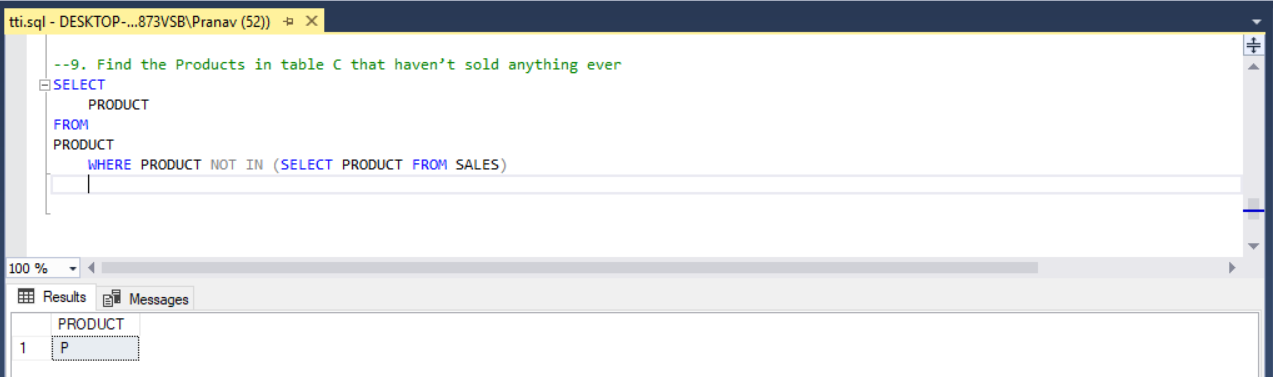

In [155]:
Image("TTIChallenge/SQLResults/Query9.png")

# Part 4  - Modeling Questions 

### i. In Python (or Pandas) write a code to import the transaction table

In [132]:
#Read the dataset into a dataframe
df = pd.read_excel("TTIChallenge/ModelingDataSet.xlsx")
col_names = df.columns
new_names = []

#Remove the trailing spaces from the exisiting column names
for i in range(len(col_names)):
    new_names.append(col_names[i].strip())
df.columns = new_names

757it [26:04,  2.07s/it]


In [10]:
#Univariate Analysis of the dataset
df.describe()

,Transaction_ID,Unit_cost,Quantity,Extended_cost,Revenue,Margin%
count,28103.000000,28103.000000,28103.000000,28103.000000,28103.000000,28103.000000
mean,14052.000000,0.210462,5556.689820,276.245760,381.811127,0.411105
std,8112.781644,0.473328,16631.417435,622.663652,790.691345,0.217018
min,1.000000,0.000008,5.000000,0.020000,4.890000,0.091326
25%,7026.500000,0.025100,200.000000,22.500000,57.750000,0.178685
50%,14052.000000,0.109778,1150.000000,86.400000,150.000000,0.443076
75%,21077.500000,0.249111,5000.000000,310.650000,427.200000,0.610069
max,28103.000000,45.849321,600000.000000,21634.120000,28938.000000,0.999927


In [11]:
df.head()

,Transaction_ID,Unit_cost,Quantity,Extended_cost,Revenue,Margin%
0,1,0.261167,1200,313.40,468.00,0.330341
1,2,1.073075,400,429.23,572.00,0.249597
2,3,0.109778,2880,316.16,662.88,0.523050
3,4,0.007200,24000,172.80,288.00,0.400000
4,5,0.012630,10000,126.30,320.00,0.605312


### a) Use your favorite classification model to segment the extended costs (Explain your code)

##### Perform Hierarchical Clustering

The scipy linkage docs tell us, 'ward' is one of the methods that can be used to calculate the distance between newly formed clusters. 'ward' causes linkage() to use the Ward variance minimization algorithm.

The data will be clustered to minimize the overall intra cluster variance in euclidean space. 

In [36]:
Z = linkage(df, 'ward')

We can see that each row of the resulting array has the format [idx1, idx2, dist, sample_count].

In its first iteration the linkage algorithm decided to merge the two clusters (original samples here) with indices 526 and 527, as they only had a distance of 1. This created a cluster with a total of 2 samples.

In [37]:
Z[0]

array([ 526.,  527.,    1.,    2.])

Results of first 10 iterations

In [38]:
Z[:10]

array([[  526.,   527.,     1.,     2.],
       [  815.,   816.,     1.,     2.],
       [ 1405.,  1406.,     1.,     2.],
       [ 3041.,  3042.,     1.,     2.],
       [ 3113.,  3114.,     1.,     2.],
       [ 3638.,  3639.,     1.,     2.],
       [ 4386.,  4387.,     1.,     2.],
       [ 5046.,  5047.,     1.,     2.],
       [ 5205.,  5206.,     1.,     2.],
       [ 5217.,  5218.,     1.,     2.]])

##### Plotting a Dendrogram
A dendrogram is a visualization in form of a tree showing the order and distances of merges during the hierarchical clustering.

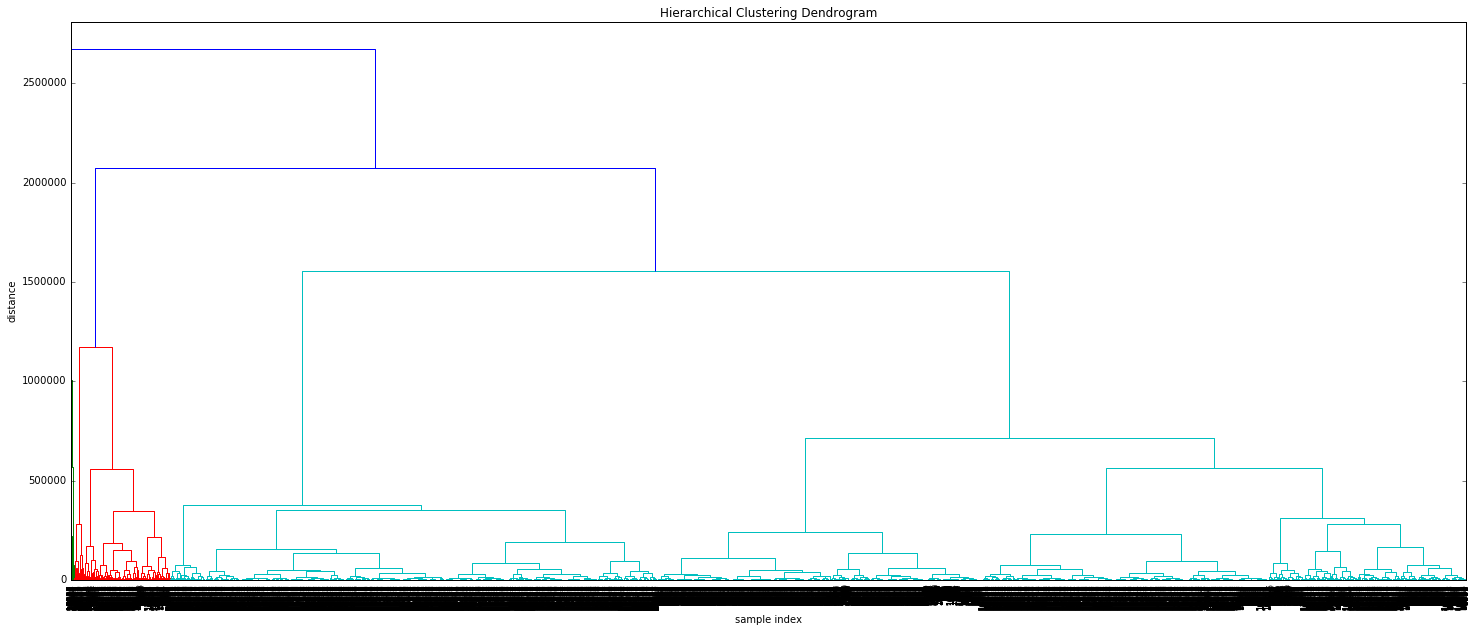

In [39]:
#Plotting a Dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

Starting from each label at the bottom, you can see a vertical line up to a horizontal line. The height of that horizontal line tells you about the distance at which this label was merged into another label or cluster. You can find that other cluster by following the other vertical line down again. If you don't encounter another horizontal line, it was just merged with the other label you reach, otherwise it was merged into another cluster that was formed earlier.
Summarizing:
horizontal lines are cluster merges vertical lines tell you which clusters/labels were part of merge forming that new cluster heights of the horizontal lines tell you about the distance that needed to be "bridged" to form the new cluster

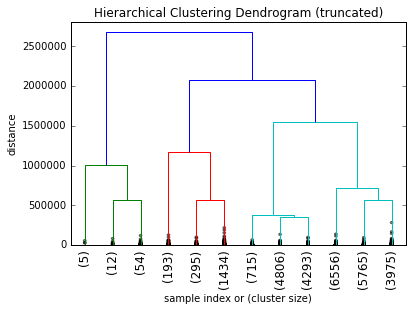

In [40]:
#This is a truncated dendrogram, which only shows the last p=12 merges.
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

Even though this already makes for quite a nice visualization, we can pimp it even more by also annotating the distances inside the dendrogram by using some of the useful return values dendrogram():

In [41]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

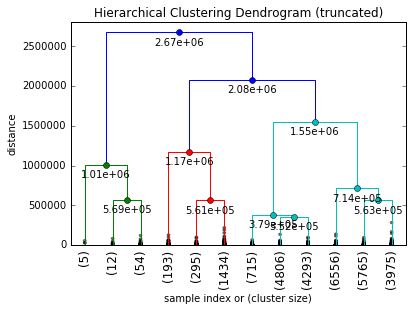

In [42]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

Selecting a Distance Cut-Off aka Determining the Number of Clusters using Elbow method

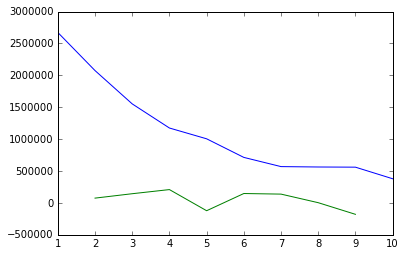

clusters: 4


In [43]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:", k)

Plotting an elbow curve between variables of interest - Extended Cost & Margin% 

It is worth noting that both the elbow curves give us optimal clusters between 4 & 5

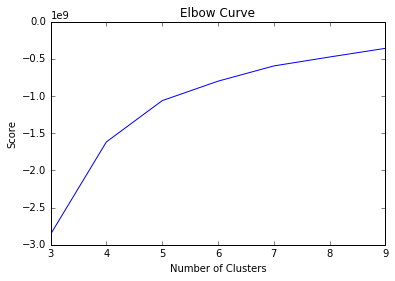

In [45]:
Y = df[['Extended_cost']]
X = df[['Margin%']]

Nc = range(3, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(Y).score(Y) for i in range(len(kmeans))]
score

pl.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

### b) Show your solution when the number of bins (nb_b) from 3 to 10 and measure the accuracy of your proposed solution with the following descriptive statistics for each bin: the average margin %, the coefficient of variation of the margin %


In [123]:
def createBinsFromClusters(clusters):
    binRanges = []
    #Create bins using cluster centroids
    for cluster in clusters:
        binRanges.append(round(cluster[0], 0).astype(int))
    
    rg = createBins(sorted(binRanges))
    print("Bin size: ", len(rg))
    print("Bin ranges: ", rg)
    
    #Create a new column called "nb_range" which stores the bin number the record belongs to. Eg - Bin 1, Bin 2, etc
    for idx, row in df.iterrows():
        for num, i in enumerate(rg):
            if i[0] <= row["Extended_cost"] <= i[1]:
                df.ix[idx, "nb_range"] = "Bin " + str(num)
    
    printmd("**The average margin%**")
    print(df.groupby(["nb_range"])["Extended_cost"].mean())

    printmd("**The coefficient of variation of the margin %**")
    print(df.groupby(["nb_range"])["Extended_cost"].std())

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Computing segmentation for clusters -  3


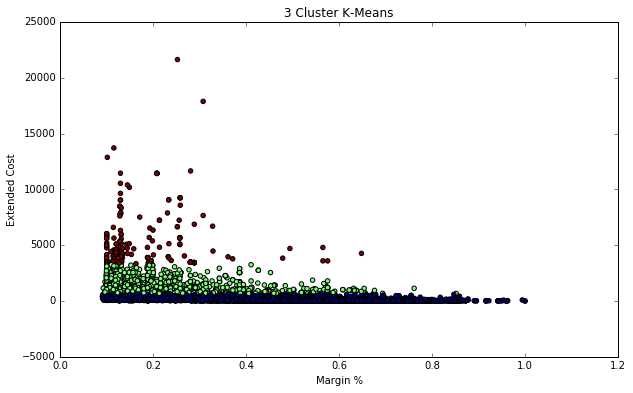

Bin size:  3
Bin size:  3
Bin ranges:  [[1, 142], [143, 1200], [1201, 5319]]


**The average margin%**

nb_range
Bin 0      43.014712
Bin 1     418.608776
Bin 2    2094.834288
Name: Extended_cost, dtype: float64


**The coefficient of variation of the margin %**

nb_range
Bin 0     35.848647
Bin 1    247.434622
Bin 2    960.223240
Name: Extended_cost, dtype: float64


 12%|██████████▌                                                                         | 1/8 [01:32<10:47, 92.49s/it]

Computing segmentation for clusters -  4


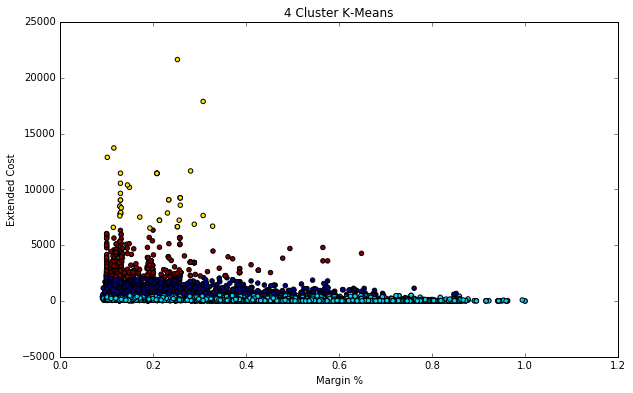

Bin size:  4
Bin size:  4
Bin ranges:  [[1, 119], [120, 894], [895, 3332], [3333, 9472]]


**The average margin%**

nb_range
Bin 0      39.332437
Bin 1     356.859884
Bin 2    1455.037497
Bin 3    4794.098274
Name: Extended_cost, dtype: float64


**The coefficient of variation of the margin %**

nb_range
Bin 0      31.750516
Bin 1     191.255102
Bin 2     549.379413
Bin 3    1506.683974
Name: Extended_cost, dtype: float64


 25%|█████████████████████                                                               | 2/8 [03:06<09:20, 93.40s/it]

Computing segmentation for clusters -  5


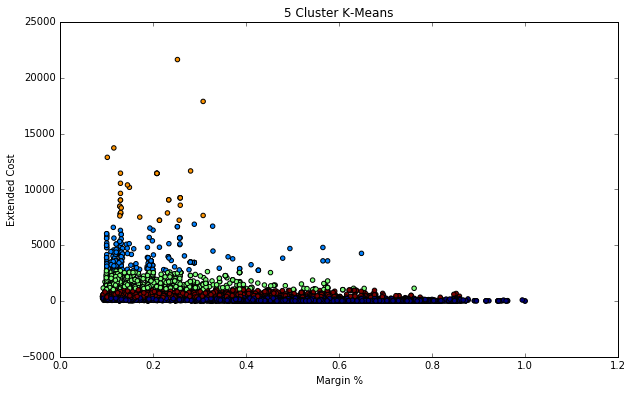

Bin size:  5
Bin size:  5
Bin ranges:  [[1, 78], [79, 534], [535, 1495], [1496, 3964], [3965, 9914]]


**The average margin%**

nb_range
Bin 0      27.931673
Bin 1     236.561627
Bin 2     841.254128
Bin 3    2292.102215
Bin 4    5457.755385
Name: Extended_cost, dtype: float64


**The coefficient of variation of the margin %**

nb_range
Bin 0      20.490765
Bin 1     130.390187
Bin 2     255.264821
Bin 3     666.331742
Bin 4    1555.272209
Name: Extended_cost, dtype: float64


 38%|███████████████████████████████▌                                                    | 3/8 [04:46<07:56, 95.36s/it]

Computing segmentation for clusters -  6


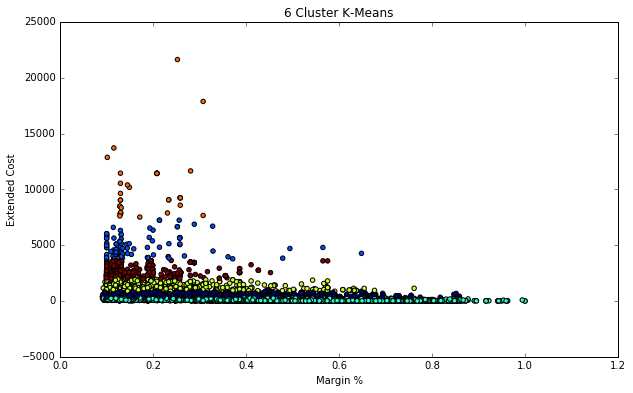

Bin size:  6
Bin size:  6
Bin ranges:  [[1, 77], [78, 503], [504, 1239], [1240, 2706], [2707, 4781], [4782, 10143]]


**The average margin%**

nb_range
Bin 0      27.296027
Bin 1     227.573997
Bin 2     756.414072
Bin 3    1694.578369
Bin 4    3591.134372
Bin 5    6512.209275
Name: Extended_cost, dtype: float64


**The coefficient of variation of the margin %**

nb_range
Bin 0      19.816292
Bin 1     124.672345
Bin 2     199.839930
Bin 3     423.309324
Bin 4     540.403218
Bin 5    1468.746875
Name: Extended_cost, dtype: float64


 50%|██████████████████████████████████████████                                          | 4/8 [06:24<06:24, 96.13s/it]

Computing segmentation for clusters -  7


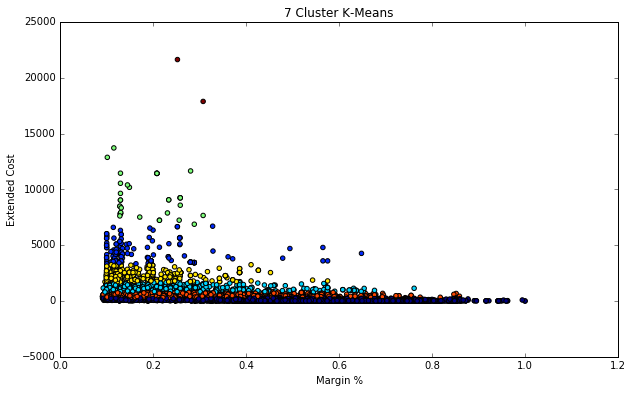

Bin size:  7
Bin size:  7
Bin ranges:  [[1, 75], [76, 482], [483, 1122], [1123, 2271], [2272, 4312], [4313, 9299], [9300, 19759]]


**The average margin%**

nb_range
Bin 0       26.975852
Bin 1      218.514498
Bin 2      694.916628
Bin 3     1454.310809
Bin 4     3114.343607
Bin 5     6134.258049
Bin 6    11823.820714
Name: Extended_cost, dtype: float64


**The coefficient of variation of the margin %**

nb_range
Bin 0      19.473974
Bin 1     117.968773
Bin 2     168.575199
Bin 3     285.655211
Bin 4     638.611493
Bin 5    1494.315772
Bin 6    2026.973594
Name: Extended_cost, dtype: float64


 62%|████████████████████████████████████████████████████▌                               | 5/8 [08:05<04:51, 97.06s/it]

Computing segmentation for clusters -  8


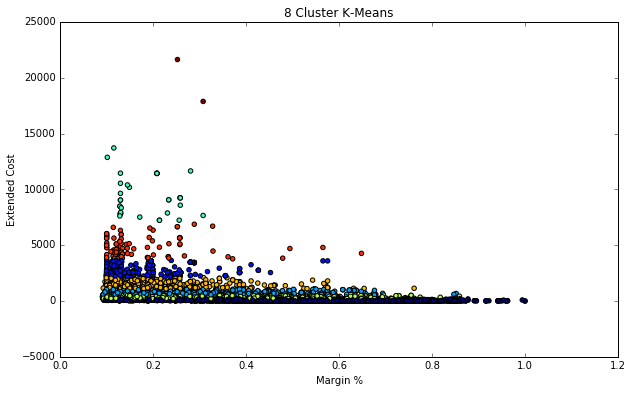

Bin size:  8
Bin size:  8
Bin ranges:  [[1, 55], [56, 336], [337, 728], [729, 1404], [1405, 2798], [2799, 4719], [4720, 9367], [9368, 19759]]


**The average margin%**

nb_range
Bin 0       21.790082
Bin 1      156.020496
Bin 2      499.023894
Bin 3     1007.841197
Bin 4     1921.868497
Bin 5     3629.858457
Bin 6     6440.997101
Bin 7    11823.820714
Name: Extended_cost, dtype: float64


**The coefficient of variation of the margin %**

nb_range
Bin 0      13.773718
Bin 1      78.090976
Bin 2     106.068011
Bin 3     195.799660
Bin 4     399.131348
Bin 5     512.664175
Bin 6    1433.361663
Bin 7    2026.973594
Name: Extended_cost, dtype: float64


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [09:46<03:15, 97.79s/it]

Computing segmentation for clusters -  9


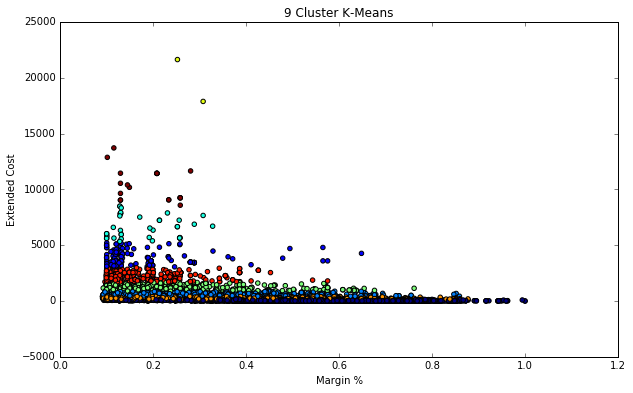

Bin size:  9
Bin size:  9
Bin ranges:  [[1, 45], [46, 257], [258, 577], [578, 1177], [1178, 2201], [2202, 3899], [3900, 6638], [6639, 10485], [10486, 19759]]


**The average margin%**

nb_range
Bin 0       19.847734
Bin 1      129.987179
Bin 2      400.998155
Bin 3      776.161559
Bin 4     1484.192246
Bin 5     2889.306336
Bin 6     4716.449524
Bin 7     8222.666333
Bin 8    12300.348182
Name: Extended_cost, dtype: float64


**The coefficient of variation of the margin %**

nb_range
Bin 0      11.880796
Bin 1      62.058295
Bin 2      84.355593
Bin 3     169.035336
Bin 4     273.305483
Bin 5     476.386567
Bin 6     679.525841
Bin 7    1028.564967
Bin 8    2035.973469
Name: Extended_cost, dtype: float64


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [11:31<01:38, 98.73s/it]

Computing segmentation for clusters -  10


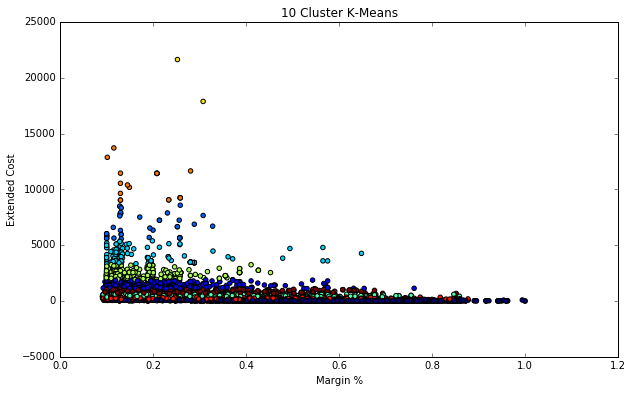

Bin size:  10
Bin size:  10
Bin ranges:  [[1, 42], [43, 224], [225, 479], [480, 820], [821, 1367], [1368, 2471], [2472, 4068], [4069, 6787], [6788, 10580], [10581, 19759]]


**The average margin%**

nb_range
Bin 0       18.486955
Bin 1      112.458096
Bin 2      341.086988
Bin 3      619.336580
Bin 4     1074.669798
Bin 5     1766.999979
Bin 6     3091.651038
Bin 7     4852.034796
Bin 8     8471.760000
Bin 9    12475.578000
Name: Extended_cost, dtype: float64


**The coefficient of variation of the margin %**

nb_range
Bin 0      10.650023
Bin 1      52.737191
Bin 2      78.352991
Bin 3      95.340053
Bin 4     153.573701
Bin 5     310.495796
Bin 6     461.311342
Bin 7     733.512137
Bin 8    1002.662855
Bin 9    2056.811877
Name: Extended_cost, dtype: float64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [13:14<00:00, 99.27s/it]


In [138]:
for num_clusters in tqdm(range(3, 11)):
    print("Computing segmentation for clusters - ", num_clusters)
    #Applying k-means to cluster the dataset
    kmeans=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
                    n_clusters=num_clusters, n_init=10, n_jobs=1, precompute_distances='auto',
                    random_state=None, tol=0.0001, verbose=0)
    #Calculating the cluster centroids
    kmeansoutput=kmeans.fit(Y)
    kmeansoutput
    
    #Plotting the k-means output
    title = str(num_clusters) + " Cluster K-Means"
    pl.figure(title)
    pl.scatter(X, Y, c=kmeansoutput.labels_)
    pl.xlabel("Margin %")
    pl.ylabel("Extended Cost")
    pl.title(title)
    pl.show()
    
    createBinsFromClusters(kmeansoutput.cluster_centers_)


### c) What column in the Transaction table could help you to differentiate the margins even better?

Since the feature importance of 'Revenue' is the highest, segmentation (splits in terms of Decision Trees) on 'Revenue' will give us better and purer terminal nodes ('Extended Cost' because it is our dependent variable). 

Features sorted by their score:
[(0.72189999999999999, 'Extended_cost'), (0.22770000000000001, 'Revenue'), (0.034299999999999997, 'Unit_cost'), (0.0161, 'Quantity')]


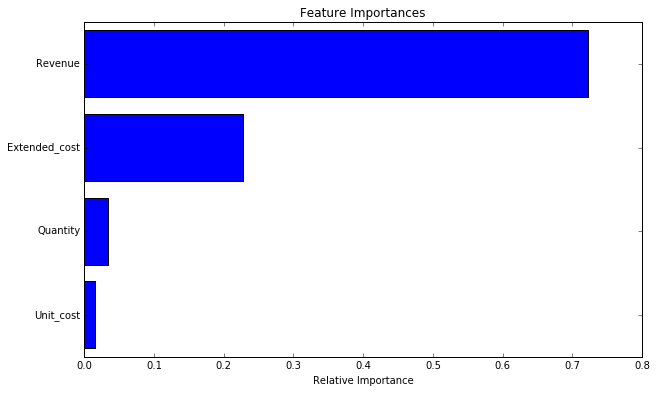

In [158]:
#Random Forest to fit the data and find feature importance

rf = RandomForestRegressor()

rf_X = df.iloc[:, [ 1, 2, 3, 4]].values
rf_y = df.iloc[:, 5].values

featureNames = ['Unit_cost', 'Quantity', 'Extended_cost', 'Revenue']

rf.fit(rf_X, rf_y)
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), featureNames), 
             reverse=True))

importances = rf.feature_importances_
indices = numpy.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), featureNames) ## removed [indices]
plt.xlabel('Relative Importance')
plt.show()